In [1]:
pip install numpy scikit-learn gensim

In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from gensim.models.keyedvectors import KeyedVectors
from datasets import load_dataset
from torchtext.vocab import GloVe



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api
from datasets import load_dataset

# Load the GloVe model (100-dimensional vectors)
glove_vectors = api.load('glove-wiki-gigaword-100')

# Load the dataset from Hugging Face
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset["train"]
test_data = dataset["test"]



[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [5]:
def document_vector(doc):
    """Create document vectors by averaging word vectors, ignoring words not in the model."""
    words = [word for word in doc if word in glove_vectors.key_to_index]
    if not words:  # Handle case where no words are in the GloVe vocabulary
        return np.zeros(glove_vectors.vector_size)
    word_vectors = [glove_vectors[word] for word in words]
    return np.mean(word_vectors, axis=0)

def preprocess_dataset(data):
    return np.array([document_vector(doc['tokens']) for doc in data])



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


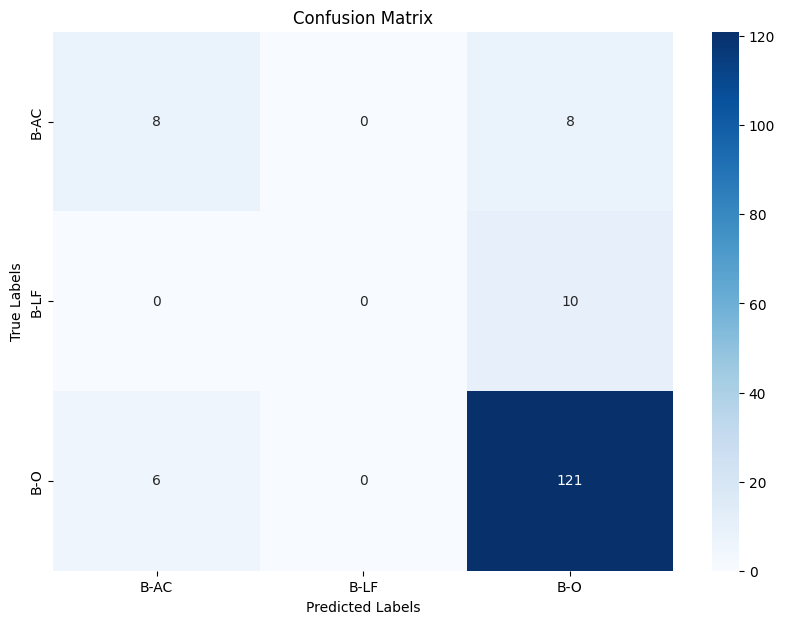

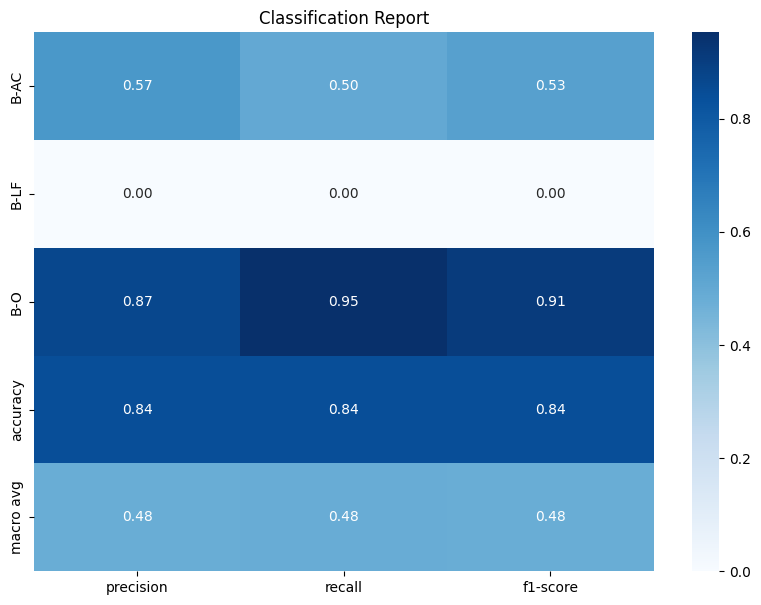

In [6]:
# Preprocess the train and test data
X_train = preprocess_dataset(train_data)
X_test = preprocess_dataset(test_data)

# Assuming labels are available and appropriate for your task, extract them as well
y_train = [example['ner_tags'][0] for example in train_data]  # Simplification: assuming one label per example
y_test = [example['ner_tags'][0] for example in test_data]

# Train the classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize the classification report
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 7))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude the last row & column for average/total
plt.title('Classification Report')
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api
from datasets import load_dataset

In [9]:
def document_vector(doc):
    """Create document vectors by averaging word vectors, ignoring words not in the model."""
    words = [word for word in doc if word in glove_vectors.key_to_index]
    if not words:  # Handle case where no words are in the GloVe vocabulary
        return np.zeros(glove_vectors.vector_size)
    word_vectors = [glove_vectors[word] for word in words]
    return np.mean(word_vectors, axis=0)

def preprocess_dataset(data):
    return np.array([document_vector(doc['tokens']) for doc in data])

# Preprocess the train and test data
X_train = preprocess_dataset(train_data)
X_test = preprocess_dataset(test_data)

# Assuming labels are available and appropriate for your task, extract them as well
y_train = [example['ner_tags'][0] for example in train_data]  # Simplification: assuming one label per example
y_test = [example['ner_tags'][0] for example in test_data]



## Applying hyper-parameter optimization

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.84


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


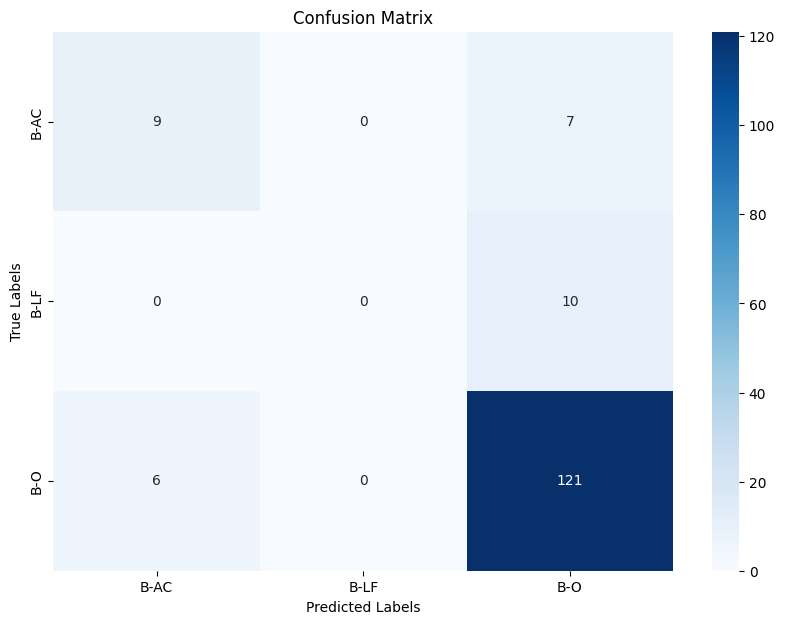

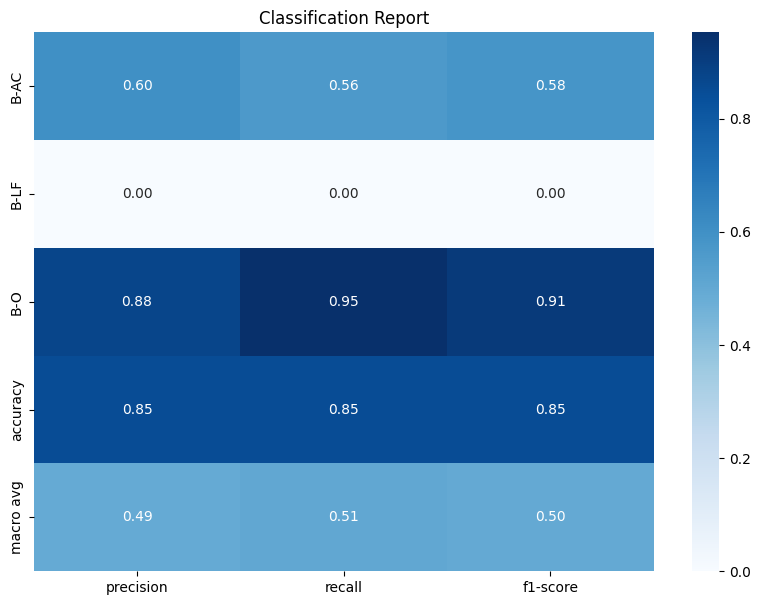

In [10]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['linear', 'rbf', 'poly']  # Type of SVM Kernel
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize the classification report
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 7))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude the last row & column for average/total
plt.title('Classification Report')
plt.show()